In [1]:
import json
import tempfile

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics

from invest_heat_islands import plot_utils, stats_utils
from invest_heat_islands.invest import utils

In [2]:
calibration_log_filepath = '../data/interim/invest/calibration-log.json'

agglom_lulc_filepath = '../data/raw/agglom-lulc.tif'
aoi_vector_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
biophysical_table_filepath = '../data/interim/biophysical-table-shade.csv'
ref_et_filepath = '../data/interim/ref-et.nc'
station_locations_filepath = '../data/raw/stations/station-locations.csv'
station_tair_filepath = '../data/interim/station-tair.csv'

In [3]:
with open(calibration_log_filepath) as src:
    calibration_log = json.load(src)
    model_params = calibration_log['args']
    rmses = calibration_log['rmses']
model_params

{'t_air_average_radius': 334.29676056419675,
 'green_area_cooling_distance': 50.28513598142648,
 'cc_weight_shade': 0.45714574056524665,
 'cc_weight_albedo': 0.1976526578371854,
 'cc_weight_eti': 0.34520160159756796}

Text(0.5, 0, '# iteration')

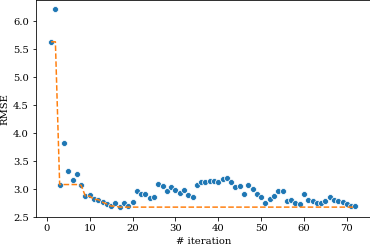

In [4]:
rmse_df = pd.DataFrame()
rmse_df['rmse'] = pd.Series(rmses,
                            index=pd.RangeIndex(start=1, stop=len(rmses) + 1))
rmse_df['cummin'] = rmse_df['rmse'].cummin()
iter_idx = rmse_df.index
color_palette = iter(sns.color_palette())
ax = sns.scatterplot(iter_idx,
                     rmse_df['rmse'].rename('RMSE'),
                     color=next(color_palette))
rmse_df['cummin'].plot(ax=ax,
                       style='--',
                       color=next(color_palette),
                       label='Best RMSE')
ax.set_xlabel('# iteration')

In [5]:
station_location_df = pd.read_csv(station_locations_filepath, index_col=0)
station_tair_df = pd.read_csv(station_tair_filepath, index_col=0)
station_tair_df.index = pd.to_datetime(station_tair_df.index)

mw = utils.ModelWrapper(    
    agglom_lulc_filepath,
    biophysical_table_filepath,
    ref_et_filepath,
    aoi_vector_filepath,
    station_tair_filepath,
    station_locations_filepath,
    model_params=model_params)

In [6]:
comparison_df = mw.get_comparison_df().dropna()
comparison_df['elev'] = comparison_df['station'].apply(
    lambda stn: station_location_df.loc[stn, 'alt'])

In [7]:
num_runs = 10

uniform_values = []
normal_values = []
for _ in range(num_runs):
    for date, date_df in comparison_df.groupby('date'):
        date_idx = date_df.index
        date_obs_ser = date_df['obs']
        T_min = date_obs_ser.min()
        T_max = date_obs_ser.max()
        num_samples = len(date_obs_ser)
        uniform_values.append(np.random.uniform(T_min, T_max,
                                                size=num_samples))
        normal_values.append(
            np.random.normal(loc=date_df['obs'].mean(),
                             scale=date_df['obs'].std(),
                             size=num_samples))
uniform_values = np.concatenate(uniform_values)
normal_values = np.concatenate(normal_values)

In [8]:
model_perf_df = pd.DataFrame(columns=stats_utils.METRIC_COLUMNS)

# Uniform/normal
obs_values = pd.concat([comparison_df['obs'] for _ in range(num_runs)])
model_perf_df.loc['Uniform'] = stats_utils.compute_model_perf(
    obs_values, uniform_values)
model_perf_df.loc['Normal'] = stats_utils.compute_model_perf(
    obs_values, normal_values)

# InVEST urban cooling model
model_perf_df.loc['InVEST UCM'] = stats_utils.compute_model_perf(
    comparison_df['obs'], comparison_df['pred'])
model_perf_df.style.set_caption('Table 1. Model performance')

,R^2,MAE,RMSE
Uniform,0.385250,2.033408,2.535604
Normal,0.533200,1.704961,2.209518
InVEST UCM,0.744069,1.273036,1.636040


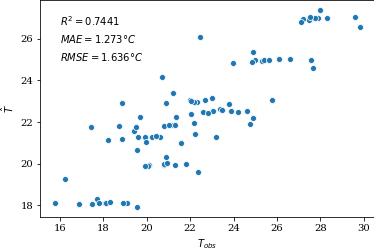

In [9]:
fig = plot_utils.plot_pred_obs(comparison_df)
fig.savefig('../reports/figures/invest-ucm-pred-obs.pdf')

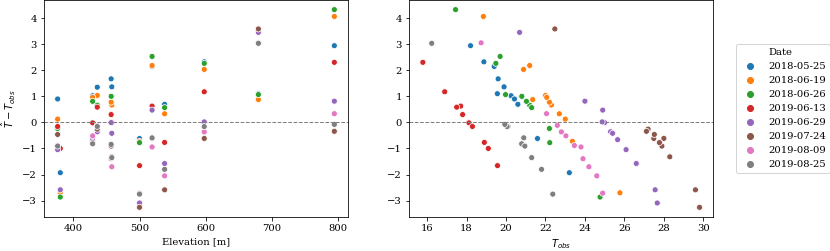

In [10]:
fig = plot_utils.plot_err_elev_obs(comparison_df)
fig.savefig('../reports/figures/invest-ucm-errors.pdf')

### Plotting the maps simulated by the calibrated urban cooling model

In [11]:
!make -C .. tair_ucm_maps

make: Entering directory '/home/martibosch/data-science/invest-heat-islands'
make: Nothing to be done for 'tair_ucm_maps'.
make: Leaving directory '/home/martibosch/data-science/invest-heat-islands'


In [12]:
T_ucm_da = mw.predict_T_da()

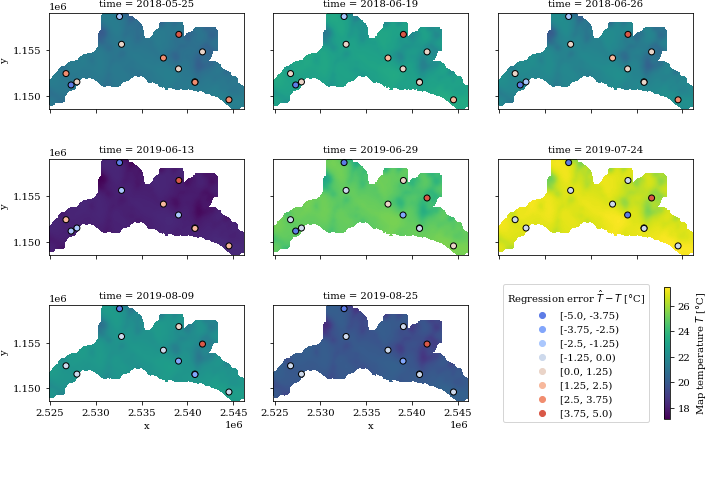

In [13]:
g = plot_utils.plot_T_maps(T_ucm_da,
                           station_location_df,
                           comparison_df=comparison_df)
g.fig.savefig('../reports/figures/invest-ucm-maps.png')